# Coleta dos dados históricos, exploração dos dados, pré-processamento e previsões com os modelos escolhidos:

## Importando e instalando as Dependências necessárias

In [1]:
!pip install yfinance
!pip install mplfinance
!pip install scikit-learn
!pip install tensorflow matplotlib
!pip install statsmodels
!pip install arch

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplfinance as mpf
from numpy.polynomial import Polynomial
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model

2024-09-19 11:18:41.481669: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-19 11:18:41.487082: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 11:18:41.535018: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 11:18:41.587429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 11:18:41.647187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Coleta dos dados históricos: ETH-USD

In [3]:
# Definindo o símbolo da cripto (ETH-USD)
symbol = 'ETH-USD'

# Coletando os dados históricos em um range de 2020-2024
eth_data = yf.download(symbol, start="2020-01-01", end="2024-09-18", interval="1d")

# Visualizando os primeiros registros
eth_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,129.630661,132.835358,129.198288,130.802002,130.802002,7935230330
2020-01-02,130.820038,130.820038,126.954910,127.410179,127.410179,8032709256
2020-01-03,127.411263,134.554016,126.490021,134.171707,134.171707,10476845358
2020-01-04,134.168518,136.052719,133.040558,135.069366,135.069366,7430904515
2020-01-05,135.072098,139.410202,135.045624,136.276779,136.276779,7526675353


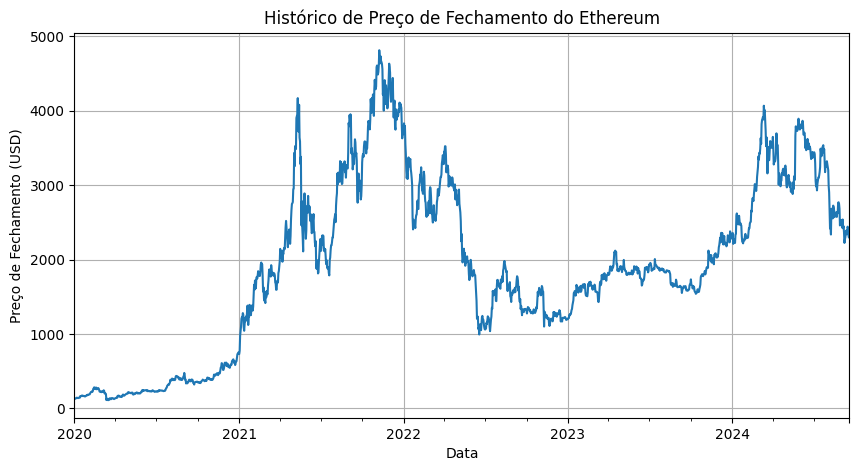

In [4]:
# Plotar os dados de fechamento (Close)
eth_data['Close'].plot(figsize=(10,5))
plt.title('Histórico de Preço de Fechamento do Ethereum')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid()
plt.show()

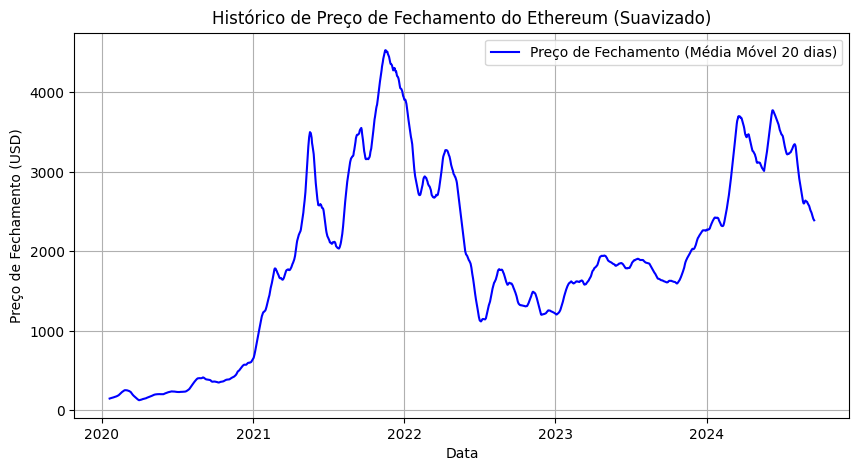

In [5]:
# Aplicando uma média móvel de 20 dias para suavizar o gráfico de fechamento
eth_data['Close_Smooth'] = eth_data['Close'].rolling(window=20).mean()

# Plotando os dados de fechamento suavizados
plt.figure(figsize=(10, 5))
plt.plot(eth_data['Close_Smooth'], label='Preço de Fechamento (Média Móvel 20 dias)', color='blue')
plt.title('Histórico de Preço de Fechamento do Ethereum (Suavizado)')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
eth_data.to_csv('eth_historical_data.csv')

## Análise exploratória: ETH-USD

In [7]:
# Examinando o formato dos dados coletados
eth_data.info()

# Exibindo as primeiras linhas dos dados
eth_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1722 entries, 2020-01-01 to 2024-09-17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1722 non-null   float64
 1   High          1722 non-null   float64
 2   Low           1722 non-null   float64
 3   Close         1722 non-null   float64
 4   Adj Close     1722 non-null   float64
 5   Volume        1722 non-null   int64  
 6   Close_Smooth  1703 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 107.6 KB


,Open,High,Low,Close,Adj Close,Volume,Close_Smooth
Date,,,,,,,
2020-01-01,129.630661,132.835358,129.198288,130.802002,130.802002,7935230330,NaN
2020-01-02,130.820038,130.820038,126.954910,127.410179,127.410179,8032709256,NaN
2020-01-03,127.411263,134.554016,126.490021,134.171707,134.171707,10476845358,NaN
2020-01-04,134.168518,136.052719,133.040558,135.069366,135.069366,7430904515,NaN
2020-01-05,135.072098,139.410202,135.045624,136.276779,136.276779,7526675353,NaN


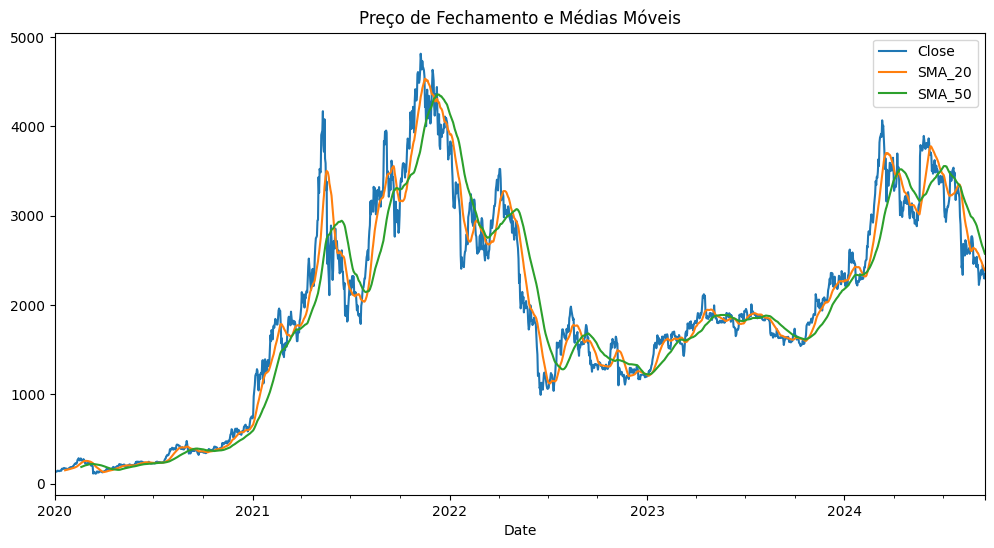

In [8]:
# Calculando médias móveis simples (SMA) de 20 e 50 dias
eth_data['SMA_20'] = eth_data['Close'].rolling(window=20).mean()
eth_data['SMA_50'] = eth_data['Close'].rolling(window=50).mean()

# Visualizando as médias móveis junto com o preço de fechamento sem suavizar
eth_data[['Close', 'SMA_20', 'SMA_50']].plot(figsize=(12, 6))
plt.title('Preço de Fechamento e Médias Móveis')
plt.show()

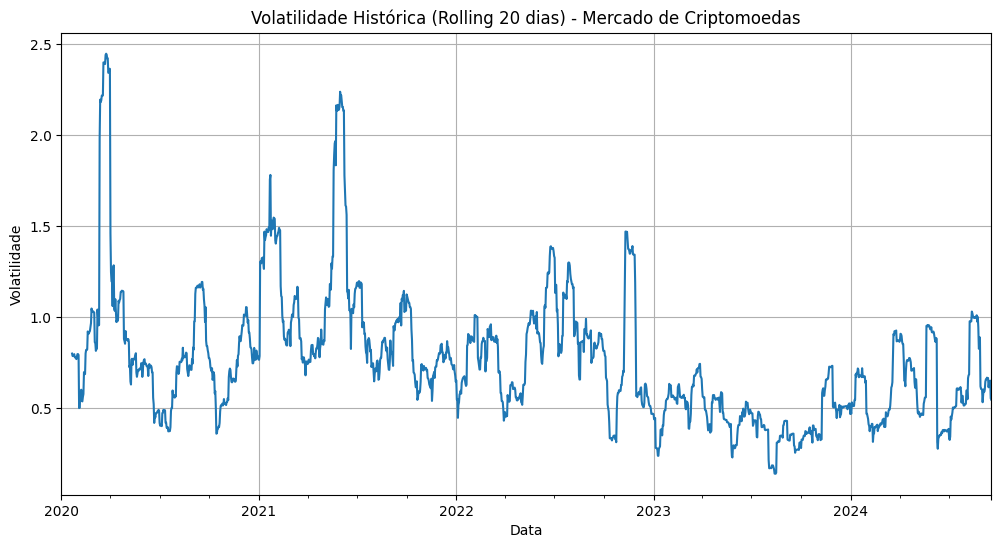

In [9]:
# Calculando a volatilidade diária (mudança percentual)
eth_data['Daily_Return'] = eth_data['Close'].pct_change()

# Calculando a volatilidade (desvio padrão da mudança percentual) com 365 dias, refletindo o mercado contínuo
eth_data['Volatility'] = eth_data['Daily_Return'].rolling(window=20).std() * np.sqrt(365)

# Plotando a volatilidade ajustada
eth_data['Volatility'].plot(figsize=(12,6))
plt.title('Volatilidade Histórica (Rolling 20 dias) - Mercado de Criptomoedas')
plt.xlabel('Data')
plt.ylabel('Volatilidade')
plt.grid(True)
plt.show()

In [10]:
# Calculando a correlação entre 'Close' (preço de fechamento) e 'Volume'
correlation = eth_data[['Close', 'Volume']].corr()

# Exibindo a correlação
print(correlation)

           Close    Volume
Close   1.000000  0.215006
Volume  0.215006  1.000000


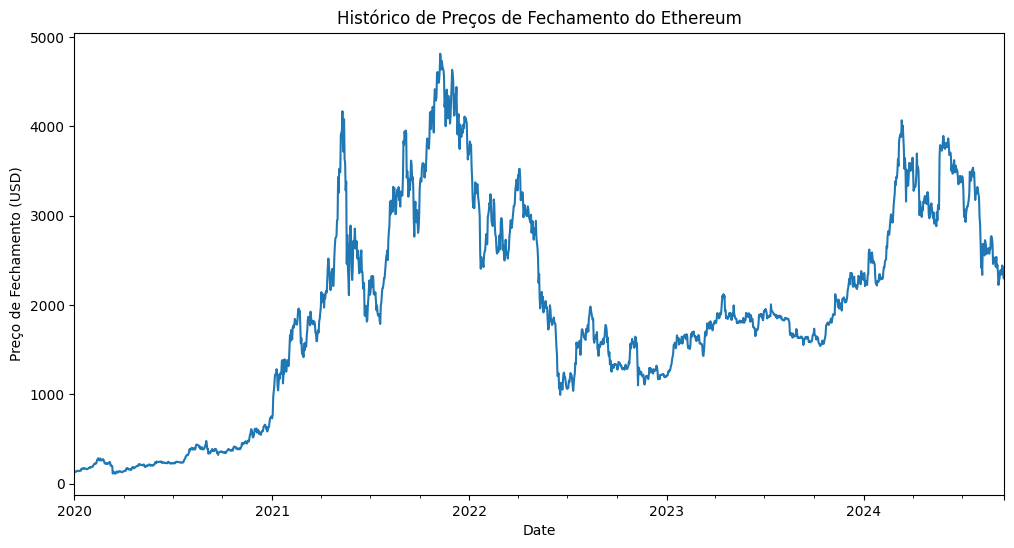

In [11]:
# Plotando o preço de fechamento para observar os padrões
eth_data['Close'].plot(figsize=(12, 6))
plt.title('Histórico de Preços de Fechamento do Ethereum')
plt.ylabel('Preço de Fechamento (USD)')
plt.show()

/home/rizzi26/Documents/GitHub/faculdade/Atividade-Ponderada-M7/src/venv/lib64/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


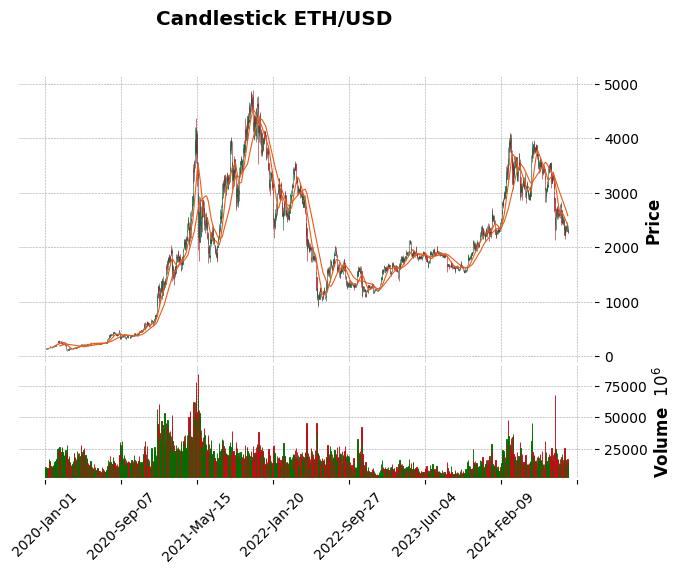

In [12]:
# Criando um gráfico de candlestick para o ETH
mpf.plot(eth_data, type='candle', style='charles', volume=True, mav=(20, 50), title="Candlestick ETH/USD")

### Analisando tendências 

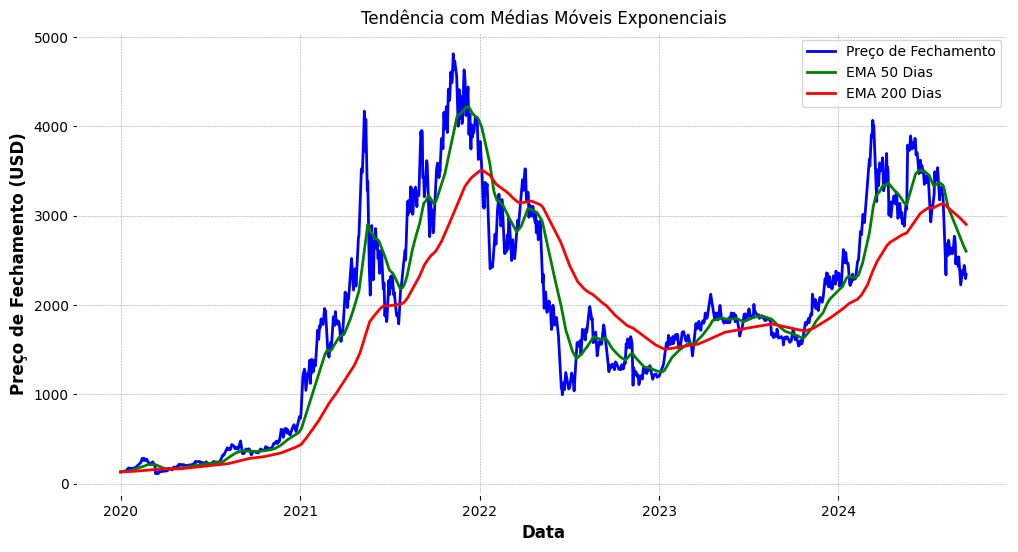

In [13]:
# Calculando Média Móvel Exponencial (EMA)
eth_data['EMA50'] = eth_data['Close'].ewm(span=50, adjust=False).mean()
eth_data['EMA200'] = eth_data['Close'].ewm(span=200, adjust=False).mean()

# Plotando o gráfico com médias móveis
plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Preço de Fechamento', color='blue')
plt.plot(eth_data['EMA50'], label='EMA 50 Dias', color='green')
plt.plot(eth_data['EMA200'], label='EMA 200 Dias', color='red')
plt.title('Tendência com Médias Móveis Exponenciais')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from numpy.polynomial import Polynomial

# Ajuste polinomial de grau 3, por exemplo
coefs = Polynomial.fit(X['Date_Ordinal'], y, 3)
eth_data['Polynomial_Trend'] = coefs(X['Date_Ordinal'])

plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Preço de Fechamento', color='blue')
plt.plot(eth_data['Polynomial_Trend'], label='Tendência Polinomial', color='orange')
plt.title('Tendência Polinomial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'X' is not defined

### Analisando de anomalias

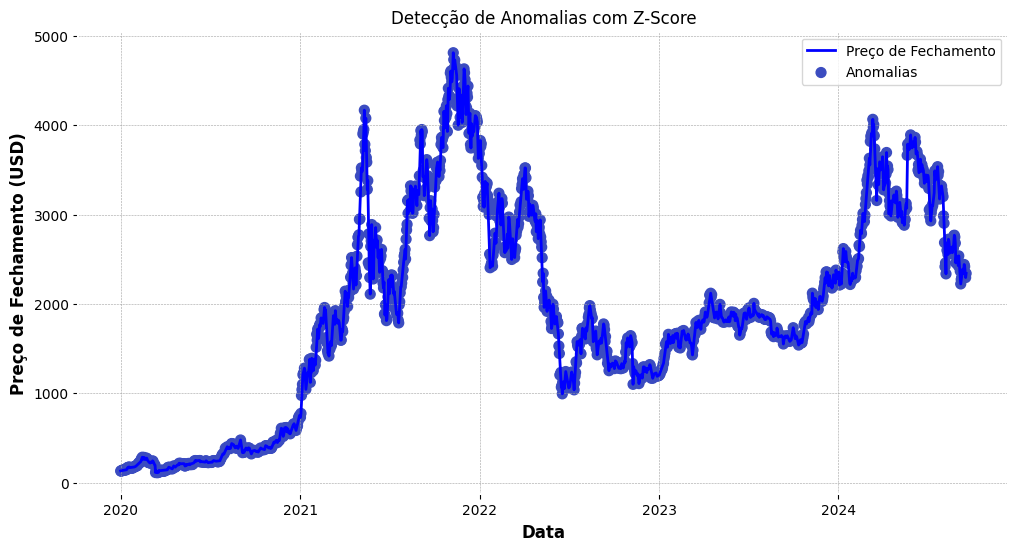

In [15]:
# Calcular o Z-Score para os preços de fechamento
eth_data['Z-Score'] = stats.zscore(eth_data['Close'].dropna())

# Definir um limite para considerar uma anomalia
anomaly_threshold = 3

# Identificar anomalias
eth_data['Anomaly'] = eth_data['Z-Score'].apply(lambda x: x if abs(x) > anomaly_threshold else 0)

# Plotar os dados e marcar as anomalias
plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Preço de Fechamento', color='blue')
plt.scatter(eth_data.index, eth_data['Close'], c=eth_data['Anomaly'], cmap='coolwarm', label='Anomalias', s=50)
plt.title('Detecção de Anomalias com Z-Score')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

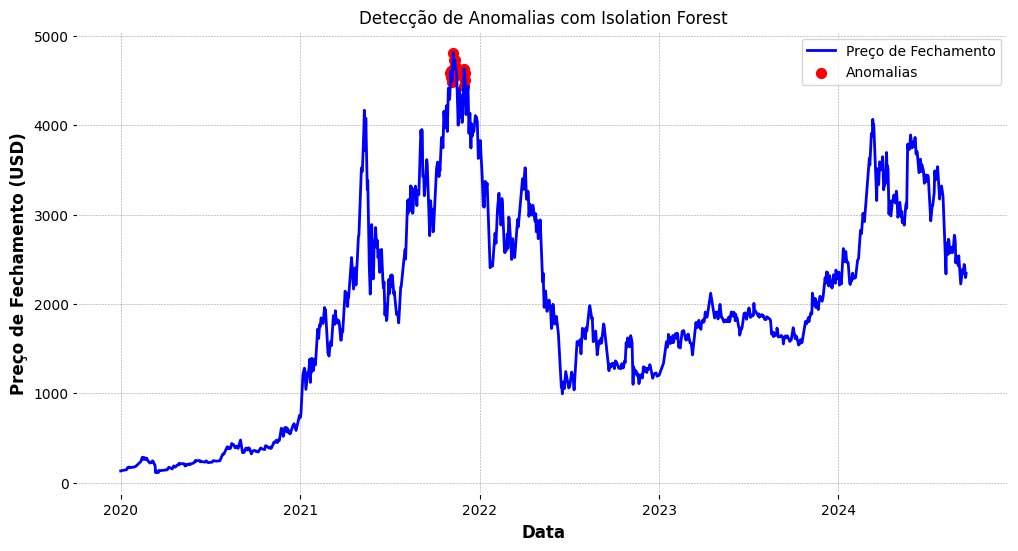

In [16]:
# Ajustar o Isolation Forest
isolation_forest = IsolationForest(contamination=0.01)
eth_data['Anomaly_IF'] = isolation_forest.fit_predict(eth_data[['Close']].dropna())

# Identificar anomalias (-1 indica anomalia)
anomalies = eth_data[eth_data['Anomaly_IF'] == -1]

# Plotar as anomalias
plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='Preço de Fechamento', color='blue')
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomalias', s=50)
plt.title('Detecção de Anomalias com Isolation Forest')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid(True)
plt.show()

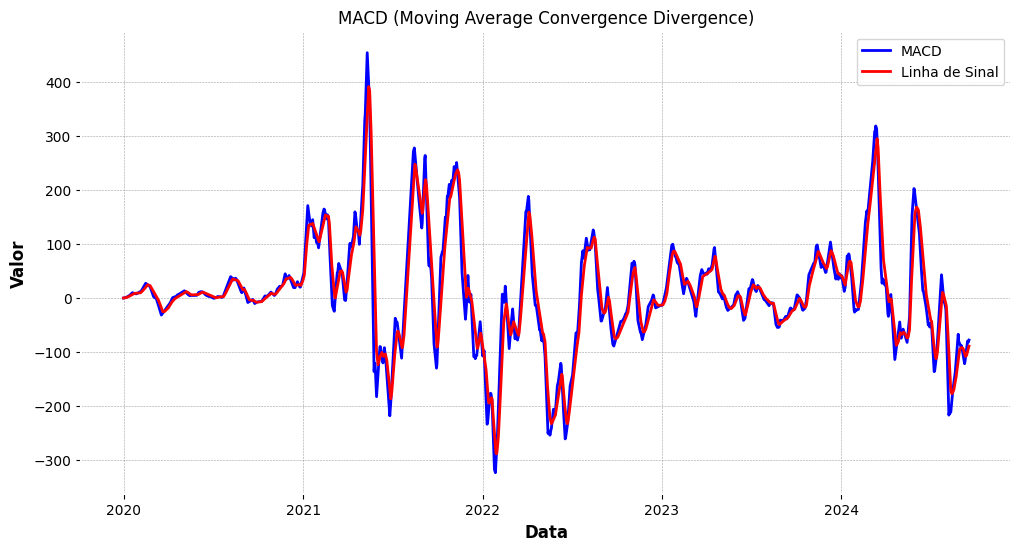

In [17]:
# MACD
eth_data['EMA12'] = eth_data['Close'].ewm(span=12, adjust=False).mean()
eth_data['EMA26'] = eth_data['Close'].ewm(span=26, adjust=False).mean()
eth_data['MACD'] = eth_data['EMA12'] - eth_data['EMA26']
eth_data['Signal_Line'] = eth_data['MACD'].ewm(span=9, adjust=False).mean()

plt.figure(figsize=(12, 6))
plt.plot(eth_data['MACD'], label='MACD', color='blue')
plt.plot(eth_data['Signal_Line'], label='Linha de Sinal', color='red')
plt.title('MACD (Moving Average Convergence Divergence)')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Pré-Processamento e rodagem de cada modelo

### LSTM

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Carregar os dados históricos do criptoativo
# Vamos supor que você tenha os preços no dataframe `df`
# Suponha que a coluna 'Close' é a que estamos interessados para prever

# 1. Remover valores ausentes
df = eth_data[['Close']].dropna()

# 2. Normalizar os dados (entre 0 e 1) para facilitar o aprendizado da LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Função para criar sequências de dados (janelas de tempo)
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])  # Features: sequências de preços passados
        y.append(data[i + time_steps, 0])    # Labels: preço futuro (próximo passo)
    return np.array(X), np.array(y)

# Definindo 60 dias como janela de tempo (você pode ajustar conforme a necessidade)
time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

# Reshape dos dados para [samples, time_steps, features] como exigido pela LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividir os dados em treino e teste
split = int(X.shape[0] * 0.8)  # 80% para treino e 20% para teste
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Construir o modelo LSTM
model = Sequential()

# Adicionando a primeira camada LSTM com Dropout para regularização
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adicionando mais uma camada LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada de saída
model.add(Dense(units=1))  # Prevendo o preço do próximo dia

# 2. Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/home/rizzi26/Documents/GitHub/faculdade/Atividade-Ponderada-M7/src/venv/lib64/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0971 - val_loss: 0.0037
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025 - val_l

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


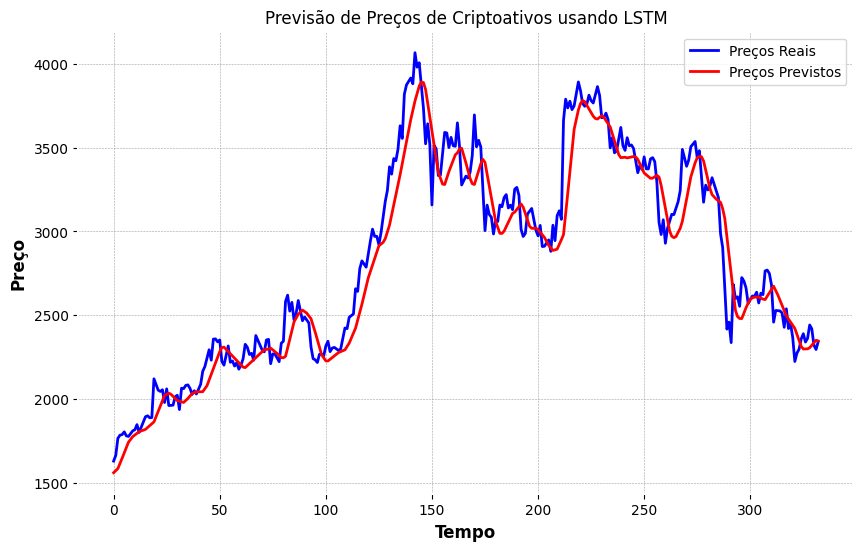

In [20]:
# Fazer previsões sobre os dados de teste
predicted_prices = model.predict(X_test)

# Desfazer a normalização para os valores previstos e reais
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotar os preços reais vs preços previstos
plt.figure(figsize=(10, 6))
plt.plot(real_prices, color='blue', label='Preços Reais')
plt.plot(predicted_prices, color='red', label='Preços Previstos')
plt.title('Previsão de Preços de Criptoativos usando LSTM')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.show()


In [21]:
def predict_future_days(model, last_sequence, num_days, scaler):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(num_days):
        # Fazer a previsão para o próximo dia
        next_prediction = model.predict(current_sequence)
        
        # Armazenar a previsão
        future_predictions.append(next_prediction[0, 0])
        
        # Redimensionar a previsão para ser compatível com a sequência de entrada
        next_prediction_reshaped = np.reshape(next_prediction, (1, 1, 1))
        
        # Atualizar a sequência com o valor previsto (remover o valor mais antigo e adicionar o novo)
        current_sequence = np.append(current_sequence[:, 1:, :], next_prediction_reshaped, axis=1)

    # Desfazer a normalização dos valores previstos
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

In [22]:
# Pegar os últimos `time_steps` do conjunto de dados de teste
last_sequence = scaled_data[-time_steps:].reshape(1, time_steps, 1)

# Prever para os próximos 7 dias
num_days = 7
future_prices = predict_future_days(model, last_sequence, num_days, scaler)

# Exibir as previsões para os próximos 7 dias
for i, price in enumerate(future_prices):
    print(f"Previsão para o dia {i+1}: {price[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Previsão para o dia 1: 2341.38
Previsão para o dia 2: 2335.76
Previsão para o dia 3: 2329.93
Previsão para o dia 4: 2324.02
Previsão para o dia 5: 2318.09
Previsão para o dia 6: 2312.16
Previsão para o dia 7: 2306.25


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


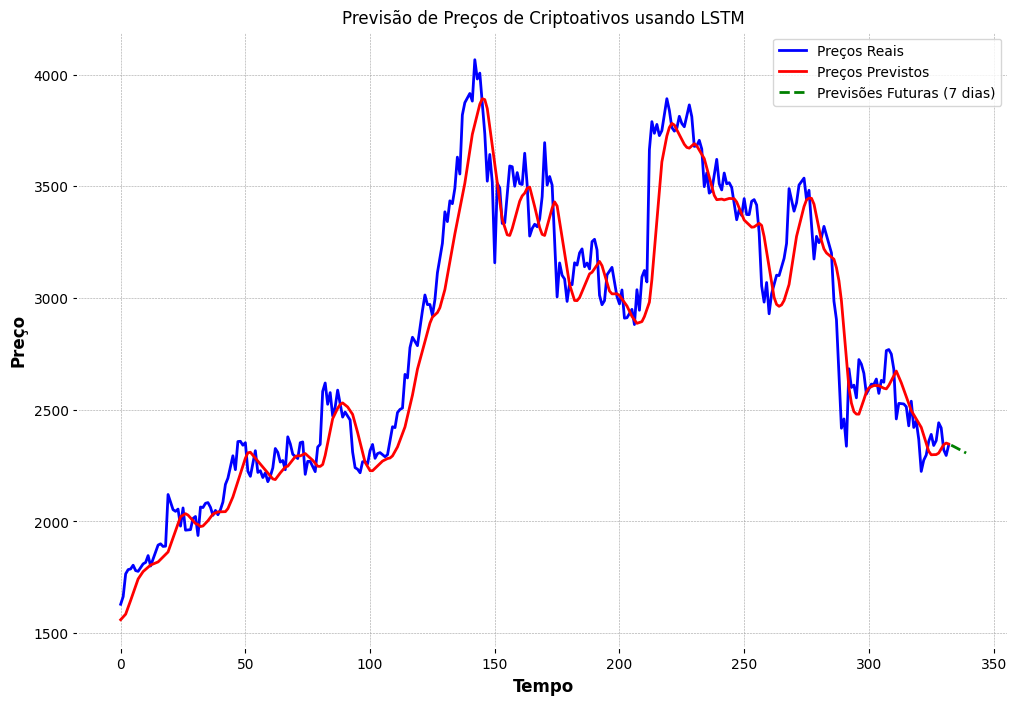

In [23]:
# Fazer previsões sobre os dados de teste
predicted_prices = model.predict(X_test)

# Desfazer a normalização para os valores previstos e reais
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Prever os próximos 7 dias
num_days = 7
last_sequence = scaled_data[-time_steps:].reshape(1, time_steps, 1)
future_prices = predict_future_days(model, last_sequence, num_days, scaler)

# Criar um vetor de tempo para as previsões futuras
future_time = np.arange(len(real_prices), len(real_prices) + num_days)

# Plotar os preços reais, preços previstos e previsões futuras
plt.figure(figsize=(12, 8))

# Plotar os dados reais
plt.plot(real_prices, color='blue', label='Preços Reais')

# Plotar os dados previstos para o conjunto de teste
plt.plot(predicted_prices, color='red', label='Preços Previstos')

# Adicionar as previsões dos próximos 7 dias
plt.plot(future_time, future_prices, color='green', label='Previsões Futuras (7 dias)', linestyle='dashed')

# Ajustar o gráfico
plt.title('Previsão de Preços de Criptoativos usando LSTM')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.show()


In [24]:
import pickle

# Supondo que `model` é o seu modelo treinado
with open('model_lstm.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Modelo salvo como 'model_lstm.pkl'")

Modelo salvo como 'model_lstm.pkl'


### GRU

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Supondo que você já tenha baixado os dados com yfinance
# df é o DataFrame com os dados históricos
df = pd.read_csv('eth_historical_data.csv')

# Filtrando a coluna de preço de fechamento ajustado
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
prices = df[['Adj Close']]

# Normalizando os preços
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

# Função para criar sequências (janelas de tempo)
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

# Criando sequências de 60 dias
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Dividindo em treino e teste (80% para treino, 20% para teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para [samples, time steps, features] que é o formato esperado pela GRU
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Construindo o modelo GRU
model = Sequential()

# Adicionando camadas GRU
model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Camada de saída
model.add(Dense(units=1))

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/home/rizzi26/Documents/GitHub/faculdade/Atividade-Ponderada-M7/src/venv/lib64/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0486 - val_loss: 0.0032
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0024 - val_loss: 8.2962e-04
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0018 - val_loss: 7.7985e-04
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0019 - val_loss: 8.9261e-04
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0019 - val_loss: 7.3843e-04
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0014 - val_loss: 7.1536e-04
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0018 - val_loss: 8.8774e-04
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0015 - val_loss: 5.8355e-04
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0013 - val_loss: 5.7636e-04
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [33]:
# Prevendo valores de teste
predicted_prices = model.predict(X_test)

# Invertendo a escala para os valores originais
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


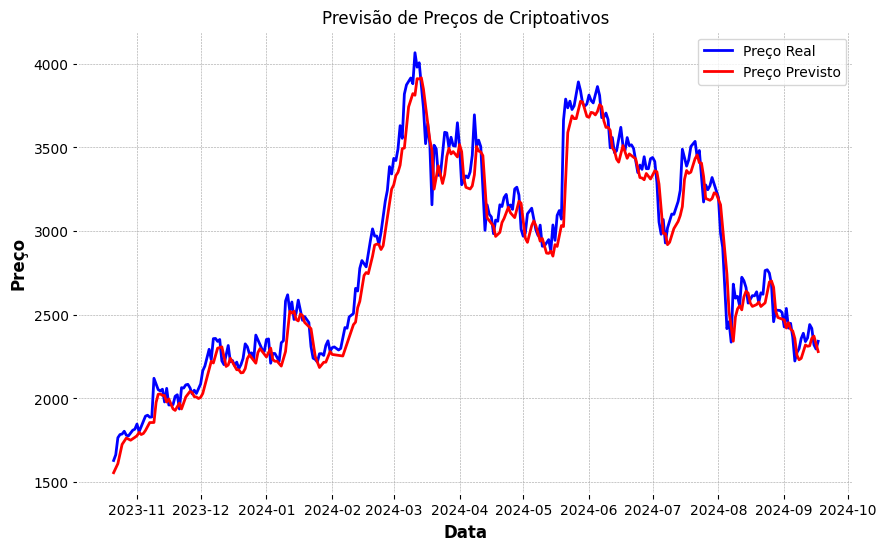

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Preços reais
plt.plot(df.index[-len(real_prices):], real_prices, color='blue', label='Preço Real')

# Preços previstos
plt.plot(df.index[-len(predicted_prices):], predicted_prices, color='red', label='Preço Previsto')

plt.title('Previsão de Preços de Criptoativos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


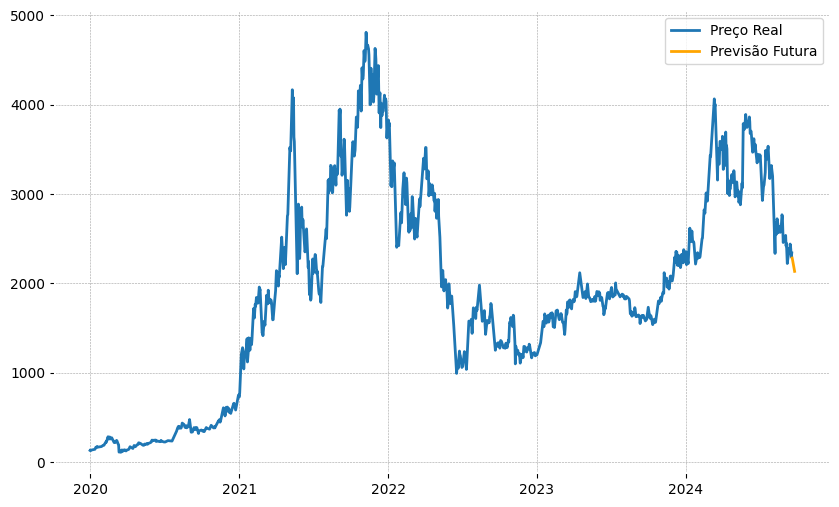

In [36]:
# Pegando os últimos 60 dias do conjunto de teste
last_sequence = scaled_data[-sequence_length:]
last_sequence = np.reshape(last_sequence, (1, sequence_length, 1))

# Fazendo previsão para os próximos 7 dias
future_predictions = []
for _ in range(7):
    prediction = model.predict(last_sequence)
    future_predictions.append(prediction[0, 0])

    # Ajuste a previsão para ter a mesma forma que `last_sequence`
    prediction_reshaped = np.reshape(prediction[0, 0], (1, 1, 1))

    # Atualize `last_sequence` com a nova previsão
    last_sequence = np.append(last_sequence[:, 1:, :], prediction_reshaped, axis=1)

# Invertendo a escala
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Adicionando os novos dias ao DataFrame e plotando
future_dates = pd.date_range(df.index[-1], periods=8, freq='D')[1:]
plt.figure(figsize=(10, 6))
plt.plot(df.index, prices, label='Preço Real')
plt.plot(future_dates, future_predictions, label='Previsão Futura', color='orange')
plt.legend()
plt.show()


In [37]:
import pickle

# Supondo que `model` é o seu modelo treinado
with open('model_gru.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Modelo salvo como 'model_gru.pkl'")

Modelo salvo como 'model_gru.pkl'
